In [32]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import root_mean_squared_error, mean_squared_error 
import pyarrow
import os

In [10]:
path = './Data/green_tripdata_'
file01 = '2021-01.parquet'
pathfile01 = path+file01

In [12]:
df = pd.read_parquet(pathfile01)

In [13]:
df.head()

,VendorID,lpep_pickup_datetime,lpep_dropoff_datetime,store_and_fwd_flag,RatecodeID,PULocationID,DOLocationID,passenger_count,trip_distance,fare_amount,extra,mta_tax,tip_amount,tolls_amount,ehail_fee,improvement_surcharge,total_amount,payment_type,trip_type,congestion_surcharge
0,2,2021-01-01 00:15:56,2021-01-01 00:19:52,N,1.0,43,151,1.0,1.01,5.5,0.5,0.5,0.00,0.0,None,0.3,6.80,2.0,1.0,0.00
1,2,2021-01-01 00:25:59,2021-01-01 00:34:44,N,1.0,166,239,1.0,2.53,10.0,0.5,0.5,2.81,0.0,None,0.3,16.86,1.0,1.0,2.75
2,2,2021-01-01 00:45:57,2021-01-01 00:51:55,N,1.0,41,42,1.0,1.12,6.0,0.5,0.5,1.00,0.0,None,0.3,8.30,1.0,1.0,0.00
3,2,2020-12-31 23:57:51,2021-01-01 00:04:56,N,1.0,168,75,1.0,1.99,8.0,0.5,0.5,0.00,0.0,None,0.3,9.30,2.0,1.0,0.00
4,2,2021-01-01 00:16:36,2021-01-01 00:16:40,N,2.0,265,265,3.0,0.00,-52.0,0.0,-0.5,0.00,0.0,None,-0.3,-52.80,3.0,1.0,0.00


In [14]:
df.dtypes

VendorID                          int64
lpep_pickup_datetime     datetime64[us]
lpep_dropoff_datetime    datetime64[us]
store_and_fwd_flag               object
RatecodeID                      float64
PULocationID                      int64
DOLocationID                      int64
passenger_count                 float64
trip_distance                   float64
fare_amount                     float64
extra                           float64
mta_tax                         float64
tip_amount                      float64
tolls_amount                    float64
ehail_fee                        object
improvement_surcharge           float64
total_amount                    float64
payment_type                    float64
trip_type                       float64
congestion_surcharge            float64
dtype: object

In [16]:
df['duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.total_seconds()/60

(0.0, 200.0)

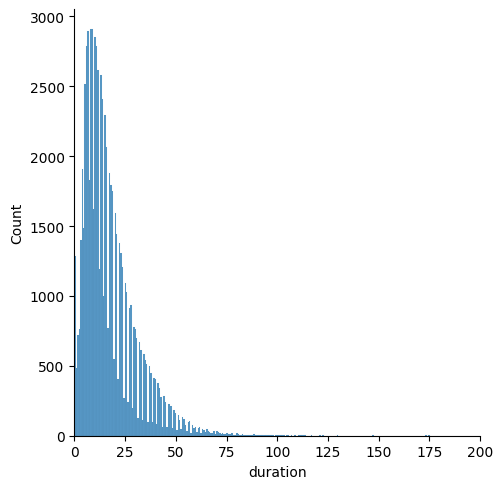

In [19]:
sns.displot(df.duration)
plt.xlim(0,200)

In [20]:
len(df)

76518

In [21]:
df = df[(df.duration >=1) & (df.duration<=60)]
len(df)

73908

In [23]:
df.DOLocationID = df.DOLocationID.astype(str)
df.PULocationID = df.PULocationID.astype(str)


In [25]:
df['PU_DO'] = df['PULocationID'] + "_" + df['DOLocationID']

In [30]:
dv = DictVectorizer()
train_set = df[['PU_DO', 'trip_distance']].to_dict(orient = 'records')
X_train = dv.fit_transform(train_set)
y_train = df.duration.values

In [36]:
train_model = LinearRegression()
train_model.fit(X_train, y_train)
y_pred = train_model.predict(X_train)

In [37]:
RMSE = root_mean_squared_error(y_train, y_pred=y_pred)
print('RMSE: ', RMSE)

RMSE:  5.699564118198979


In [45]:
def model_training(train_file: str, val_file: str, model):
    
    path = './Data/green_tripdata_'
    train_path = path + train_file + '.parquet'
    val_path = path + val_file + '.parquet'
    
    train_data = pd.read_parquet(train_path)
    train_data['duration'] = (train_data.lpep_dropoff_datetime - train_data.lpep_pickup_datetime).dt.total_seconds()/60
    train_data = train_data[(train_data.duration >=1) & (train_data.duration <= 60)]
    train_data.PULocationID = train_data.PULocationID.astype(str)
    train_data.DOLocationID = train_data.DOLocationID.astype(str)
    train_data['PU_DO'] = train_data.PULocationID + "_" + train_data.DOLocationID
    train_set = train_data[['PU_DO','trip_distance']]
    train_set = train_set.to_dict(orient = 'records')
    
    dv = DictVectorizer()
    X_train = dv.fit_transform(train_set)
    y_train = train_data.duration.values
    
    val_data = pd.read_parquet(val_path)
    val_data['duration'] = (val_data.lpep_dropoff_datetime - val_data.lpep_pickup_datetime).dt.total_seconds()/60
    val_data = val_data[(val_data.duration >=1) & (val_data.duration <= 60)]
    val_data.PULocationID = val_data.PULocationID.astype(str)
    val_data.DOLocationID = val_data.DOLocationID.astype(str)
    val_data['PU_DO'] = val_data.PULocationID + "_" + val_data.DOLocationID
    val_set = val_data[['PU_DO','trip_distance']]
    val_set = val_set.to_dict(orient = 'records')
    
    X_val = dv.transform(val_set)
    y_val = val_data.duration.values
    
    prediction_model = model()
    prediction_model.fit(X_train, y_train)
    y_pred = prediction_model.predict(X_train)
    
    print("Model: ", prediction_model)
    print("Training RMSE: ", root_mean_squared_error(y_train, y_pred))
    
    y_val_pred = prediction_model.predict(X_val)
    print("Validation RMSE: ", root_mean_squared_error(y_val, y_val_pred))
    
    return prediction_model, y_pred, y_val_pred
    
    
    

In [47]:
model, y_pred, y_val_pred = model_training('2021-01', '2021-02', LinearRegression)

Model:  LinearRegression()
Training RMSE:  5.699564118198979
Validation RMSE:  7.758715209663881
